<a href="https://colab.research.google.com/github/krisnur/mnr/blob/master/maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Model to Predict Tyre Maintenance**

1.   Mount data in csv formatted from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2.   Import the data and check by summary function



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import pickle

In [ ]:
# Specify the path to the CSV file within your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/data/maintenance_data.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Summarize data statistics
print(data.describe(include='all'))

                  id    nopol  m_mechanic_id request_date completed_date  \
count   11951.000000    11924   11951.000000        11933          11935   
unique           NaN      283            NaN         3091           3102   
top              NaN  H9188OW            NaN   2016-01-12     2016-01-12   
freq             NaN      188            NaN           18             18   
mean    18850.532759      NaN      20.862187          NaN            NaN   
std      9634.955460      NaN       7.359939          NaN            NaN   
min         2.000000      NaN       0.000000          NaN            NaN   
25%     11459.500000      NaN      19.000000          NaN            NaN   
50%     17740.000000      NaN      19.000000          NaN            NaN   
75%     27661.500000      NaN      19.000000          NaN            NaN   
max     35973.000000      NaN      55.000000          NaN            NaN   

            start_km       last_km service_name     created  truck_year_build  \
count 

In [ ]:
# Display the first few rows of your data
print(data.head())

    id    nopol  m_mechanic_id request_date completed_date  start_km  \
0  130  H1820DY              8   2011-11-04     2011-11-04   45581.0   
1  131  H9789OW             10   2011-11-04     2011-11-04  260134.0   
2  150  H8546OW              7   2011-11-08     2011-11-08   62017.0   
3  170  H1784EY              7   2011-11-14     2011-11-14  151248.0   
4  171  H9023OW              8   2011-11-14     2011-11-14   55619.0   

    last_km   service_name     created  truck_year_build truck_status  
0   55581.0  SERVICE BESAR  2011-11-04            2008.0            A  
1  270134.0  SERVICE BESAR  2011-11-04            2008.0            A  
2   72017.0  SERVICE BESAR  2011-11-08            2010.0            A  
3  161248.0  SERVICE BESAR  2011-11-14            2009.0            A  
4   65619.0  SERVICE BESAR  2011-11-14            2010.0            A  


In [ ]:
sorted_data = data.sort_values(by=['nopol', 'id'], ascending=[True, True])

print(sorted_data.head())


         id     nopol  m_mechanic_id request_date completed_date  start_km  \
6607  18436  B9070UEJ             33   2017-02-20     2017-02-20   83635.9   
6637  18548  B9070UEJ             33   2017-03-14     2017-03-14   88294.8   
6710  18820  B9070UEJ             33   2017-04-01     2017-04-01   89443.6   
6711  18821  B9070UEJ             33   2017-04-20     2017-04-20   91295.6   
4796  18822  B9070UEJ             33   2017-04-01     2017-04-01   89443.6   

       last_km   service_name     created  truck_year_build truck_status  
6607   93635.9           TYRE  2017-03-03            2012.0            A  
6637   98294.8           TYRE  2017-03-16            2012.0            A  
6710  119443.6           TYRE  2017-04-26            2012.0            A  
6711  121295.6           TYRE  2017-04-26            2012.0            A  
4796   99443.6  SERVICE RUTIN  2017-04-26            2012.0            A  


In [ ]:
# Select specific columns
selected_columns = sorted_data[['nopol', 'service_name', 'start_km']].sort_values(by=['nopol'], ascending=[True])

# Rename the 'nopol' column to 'police_no'
selected_columns.rename(columns={'nopol': 'police_no'}, inplace=True)
selected_columns.rename(columns={'start_km': 'current_km'}, inplace=True)

print(selected_columns.head())


     police_no   service_name  current_km
6607  B9070UEJ           TYRE     83635.9
9670  B9070UEJ           TYRE    314888.0
9671  B9070UEJ           TYRE    318624.0
8039  B9070UEJ  SERVICE RUTIN    280446.0
8040  B9070UEJ  SERVICE RUTIN    291880.0


In [ ]:
grouped_data = selected_columns.sort_values(by=['police_no'])

# Create a new column 'previous_start_km'
grouped_data['previous_km'] = grouped_data.groupby('police_no')['current_km'].shift(1)

# Fill missing values in 'previous_start_km' with 0 or any other appropriate value
grouped_data['previous_km'].fillna(0, inplace=True)

# Calculate the gap between 'start_km' and 'previous_start_km'
grouped_data['km_gap'] = grouped_data['current_km'] - grouped_data['previous_km']

# Set 'km_gap' to 0 when 'previous_start_km' is 0
grouped_data.loc[grouped_data['previous_km'] == 0, 'km_gap'] = 0

print(grouped_data.head(25))

     police_no   service_name  current_km  previous_km    km_gap
6607  B9070UEJ           TYRE     83635.9          0.0       0.0
6637  B9070UEJ           TYRE     88294.8      83635.9    4658.9
6710  B9070UEJ           TYRE     89443.6      88294.8    1148.8
6711  B9070UEJ           TYRE     91295.6      89443.6    1852.0
4796  B9070UEJ  SERVICE RUTIN     89443.6      91295.6   -1852.0
6743  B9070UEJ           TYRE     91795.6      89443.6    2352.0
6825  B9070UEJ           TYRE     96927.4      91795.6    5131.8
7052  B9070UEJ           TYRE     98976.0      96927.4    2048.6
9016  B9070UEJ           TYRE    254308.0      98976.0  155332.0
9667  B9070UEJ           TYRE    280489.0     254308.0   26181.0
8783  B9070UEJ     TAMBAH OLI    226025.0     280489.0  -54464.0
7553  B9070UEJ  SERVICE RUTIN    226025.0     226025.0       0.0
7554  B9070UEJ  SERVICE RUTIN    237354.0     226025.0   11329.0
7283  B9070UEJ  SERVICE BESAR    237354.0     237354.0       0.0
8852  B9070UEJ           

In [ ]:
# Remove negative value

remove_nagative_val_data = grouped_data[grouped_data['km_gap'] >= 0]

print(remove_nagative_val_data.head(25))

     police_no   service_name  current_km  previous_km    km_gap
6607  B9070UEJ           TYRE     83635.9          0.0       0.0
6637  B9070UEJ           TYRE     88294.8      83635.9    4658.9
6710  B9070UEJ           TYRE     89443.6      88294.8    1148.8
6711  B9070UEJ           TYRE     91295.6      89443.6    1852.0
6743  B9070UEJ           TYRE     91795.6      89443.6    2352.0
6825  B9070UEJ           TYRE     96927.4      91795.6    5131.8
7052  B9070UEJ           TYRE     98976.0      96927.4    2048.6
9016  B9070UEJ           TYRE    254308.0      98976.0  155332.0
9667  B9070UEJ           TYRE    280489.0     254308.0   26181.0
7553  B9070UEJ  SERVICE RUTIN    226025.0     226025.0       0.0
7554  B9070UEJ  SERVICE RUTIN    237354.0     226025.0   11329.0
7283  B9070UEJ  SERVICE BESAR    237354.0     237354.0       0.0
8852  B9070UEJ           TYRE    237354.0     237354.0       0.0
8853  B9070UEJ           TYRE    238934.0     237354.0    1580.0
8925  B9070UEJ           

In [ ]:
# selected only service_nam = TYRE
filter_by_tyre_data = remove_nagative_val_data[remove_nagative_val_data['service_name'] == 'TYRE']

print(filter_by_tyre_data.head(15))

# Set the display options to show two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# Summarize data statistics
print(filter_by_tyre_data.describe(include='all'))

     police_no service_name  current_km  previous_km    km_gap
6607  B9070UEJ         TYRE     83635.9          0.0       0.0
6637  B9070UEJ         TYRE     88294.8      83635.9    4658.9
6710  B9070UEJ         TYRE     89443.6      88294.8    1148.8
6711  B9070UEJ         TYRE     91295.6      89443.6    1852.0
6743  B9070UEJ         TYRE     91795.6      89443.6    2352.0
6825  B9070UEJ         TYRE     96927.4      91795.6    5131.8
7052  B9070UEJ         TYRE     98976.0      96927.4    2048.6
9016  B9070UEJ         TYRE    254308.0      98976.0  155332.0
9667  B9070UEJ         TYRE    280489.0     254308.0   26181.0
8852  B9070UEJ         TYRE    237354.0     237354.0       0.0
8853  B9070UEJ         TYRE    238934.0     237354.0    1580.0
8925  B9070UEJ         TYRE    245401.0     238934.0    6467.0
7175  B9070UEJ         TYRE    224746.0     219527.0    5219.0
9668  B9070UEJ         TYRE    291880.0     224746.0   67134.0
9670  B9070UEJ         TYRE    314888.0     307907.0   

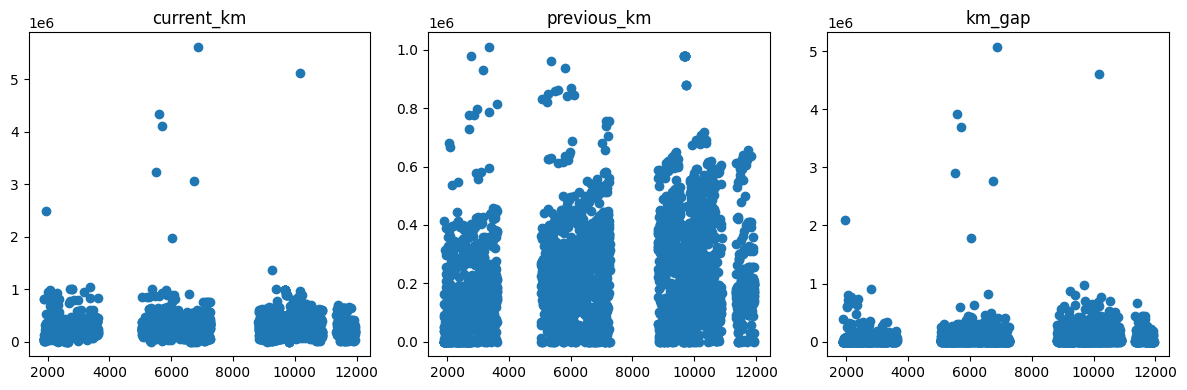

In [ ]:
# Looking for outlier

# Create a scatter plot for each column to visualize outliers
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(filter_by_tyre_data.index, filter_by_tyre_data['current_km'])
plt.title('current_km')

plt.subplot(132)
plt.scatter(filter_by_tyre_data.index, filter_by_tyre_data['previous_km'])
plt.title('previous_km')

plt.subplot(133)
plt.scatter(filter_by_tyre_data.index, filter_by_tyre_data['km_gap'])
plt.title('km_gap')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the Z-score for each data point
z_scores = np.abs(stats.zscore(filter_by_tyre_data['current_km']))

# Define a threshold for outliers (e.g., 2 standard deviations)
threshold = 2

# Identify outliers
outliers = filter_by_tyre_data[np.abs(z_scores) > threshold]

# Filter out outliers and create a new DataFrame
df_no_outliers = filter_by_tyre_data[np.abs(z_scores) <= threshold]

print("Outliers:")
print(outliers)

print("Clean Data:")
print(df_no_outliers)

Outliers:
      police_no service_name  current_km  previous_km     km_gap
9397   B9923UYV         TYRE   998889.00    198245.00  800644.00
6882    H1781EY         TYRE  5611105.00    537292.00 5073813.00
10153   H1784EY         TYRE   808082.00    130325.00  677757.00
1957    H1786EY         TYRE  2482443.00    390153.00 2092290.00
5697    H1790EY         TYRE  4098790.00    406612.00 3692178.00
...         ...          ...         ...          ...        ...
1884    H9639OW         TYRE   809339.00    413350.00  395989.00
2024    H9789OW         TYRE   949448.00    356856.00  592592.00
10232   L9762UW         TYRE   885678.00    118988.00  766690.00
6122    L9763UW         TYRE   807387.00    176813.00  630574.00
6020    L9766UW         TYRE  1979944.00    196355.00 1783589.00

[75 rows x 5 columns]
Clean Data:
      police_no service_name  current_km  previous_km  km_gap
6607   B9070UEJ         TYRE    83635.90         0.00    0.00
6637   B9070UEJ         TYRE    88294.80     83635.

In [ ]:
df_no_outliers_no_nan = df_no_outliers.dropna()

print("Clean Data No NaN :")
print(df_no_outliers_no_nan)

Clean Data No NaN :
     police_no service_name  current_km  previous_km    km_gap
6607  B9070UEJ         TYRE    83635.90         0.00      0.00
6637  B9070UEJ         TYRE    88294.80     83635.90   4658.90
6710  B9070UEJ         TYRE    89443.60     88294.80   1148.80
6711  B9070UEJ         TYRE    91295.60     89443.60   1852.00
6743  B9070UEJ         TYRE    91795.60     89443.60   2352.00
...        ...          ...         ...          ...       ...
9781   L9768UW         TYRE   146047.00    146047.00      0.00
9782   L9768UW         TYRE   282138.00    146047.00 136091.00
9783   L9768UW         TYRE   282138.00    282138.00      0.00
9785   L9768UW         TYRE   175828.00    166610.00   9218.00
9784   L9768UW         TYRE   282138.00    175828.00 106310.00

[4029 rows x 5 columns]


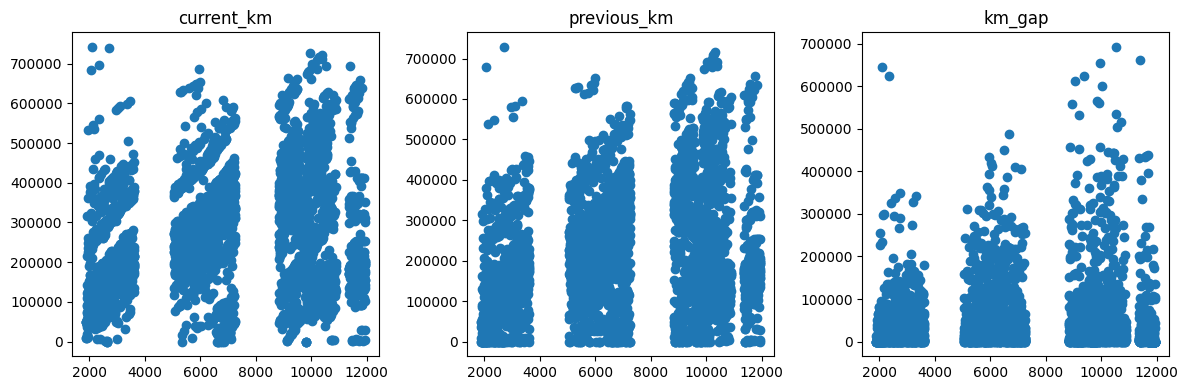

In [ ]:
# Looking for outlier

# Create a scatter plot for each column to visualize outliers
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(df_no_outliers_no_nan.index, df_no_outliers_no_nan['current_km'])
plt.title('current_km')

plt.subplot(132)
plt.scatter(df_no_outliers_no_nan.index, df_no_outliers_no_nan['previous_km'])
plt.title('previous_km')

plt.subplot(133)
plt.scatter(df_no_outliers_no_nan.index, df_no_outliers_no_nan['km_gap'])
plt.title('km_gap')

plt.tight_layout()
plt.show()

In [ ]:
# Summarize data statistics
print(df_no_outliers_no_nan.describe(include='all'))

       police_no service_name  current_km  previous_km    km_gap
count       4029         4029     4029.00      4029.00   4029.00
unique       207            1         NaN          NaN       NaN
top      H9188OW         TYRE         NaN          NaN       NaN
freq          88         4029         NaN          NaN       NaN
mean         NaN          NaN   268531.25    224572.55  40612.86
std          NaN          NaN   143536.07    146442.12  78450.18
min          NaN          NaN        0.00         0.00      0.00
25%          NaN          NaN   159420.00    114626.00   2195.00
50%          NaN          NaN   251748.00    202761.00   7584.00
75%          NaN          NaN   362540.00    318428.00  41827.00
max          NaN          NaN   741980.00    728424.00 692378.00


In [ ]:
# Correlation matrix

# Compute the correlation matrix
correlation_matrix = filter_by_tyre_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Compute the correlation matrix
correlation_matrix_df_no_outliers_no_nan = df_no_outliers_no_nan.corr()

# Display the correlation matrix
print(correlation_matrix_df_no_outliers_no_nan)

             current_km  previous_km  km_gap
current_km         1.00         0.61    0.73
previous_km        0.61         1.00   -0.07
km_gap             0.73        -0.07    1.00
             current_km  previous_km  km_gap
current_km         1.00         0.84    0.27
previous_km        0.84         1.00   -0.26
km_gap             0.27        -0.26    1.00


<ipython-input-15-5097ea3eb9c4>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = filter_by_tyre_data.corr()
<ipython-input-15-5097ea3eb9c4>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_df_no_outliers_no_nan = df_no_outliers_no_nan.corr()


In [ ]:
# Create ML Model

df = filter_by_tyre_data

# Data preprocessing (convert categorical variables if needed)

# Split the data into features and target variable
X = df[['previous_km', 'km_gap']]
y = df['current_km']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 27621.434139595054
R-squared (R2): 0.986791538396325


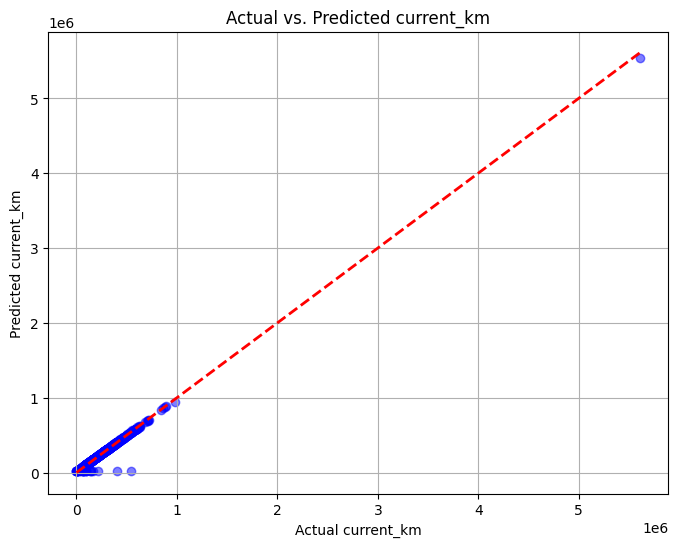

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)
plt.title('Actual vs. Predicted current_km')
plt.xlabel('Actual current_km')
plt.ylabel('Predicted current_km')
plt.grid(True)

# Add a diagonal line for reference (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

# Show the plot
plt.show()



In [ ]:
# Assuming you have already trained the model and loaded the data

# Define the values for 'previous_km' and 'km_gap' that you want to predict for
new_previous_km = 330000
new_km_gap = 60000

# Create a DataFrame with the new values
new_data = pd.DataFrame({'previous_km': [new_previous_km], 'km_gap': [new_km_gap]})

# Use the trained model to make predictions
predicted_current_km = model.predict(new_data)

# Display the predicted 'current_km'
print(f"Predicted current_km: {predicted_current_km[0]}")

Predicted current_km: 390403.3805976351


In [ ]:
# Load and preprocess your data as needed
# Create ML Model

df = filter_by_tyre_data

# Split the data into features (X) and target variable (y)
X = df[['previous_km', 'km_gap']]
y = df['current_km']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a simple neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a linear activation
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Calculate RMSE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Epoch 1/100
104/104 [==============================] - 2s 4ms/step - loss: 38179074048.0000 - mean_absolute_error: 122509.7578
Epoch 2/100
104/104 [==============================] - 0s 3ms/step - loss: 2116925568.0000 - mean_absolute_error: 13558.0605
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 1980194176.0000 - mean_absolute_error: 10002.6465
Epoch 4/100
104/104 [==============================] - 0s 2ms/step - loss: 1946619392.0000 - mean_absolute_error: 8062.4580
Epoch 5/100
104/104 [==============================] - 0s 2ms/step - loss: 1921751552.0000 - mean_absolute_error: 6357.2559
Epoch 6/100
104/104 [==============================] - 0s 2ms/step - loss: 1918323712.0000 - mean_absolute_error: 5835.3960
Epoch 7/100
104/104 [==============================] - 0s 2ms/step - loss: 1917438720.0000 - mean_absolute_error: 5748.3999
Epoch 8/100
104/104 [==============================] - 0s 2ms/step - loss: 1917042048.0000 - mean_absolute_error: 5677.9395
Epo

In [ ]:
# Sample data preprocessing and splitting
# Replace with your actual data preprocessing and splitting steps
# X_train, X_test, y_train, y_test = ...
# Load and preprocess your data as needed
# Create ML Model

df = filter_by_tyre_data

# Split the data into features (X) and target variable (y)
X = df[['previous_km', 'km_gap']]
y = df['current_km']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize dictionaries to store model names and their corresponding results
model_names = []
rmse_values = []
r2_values = []

# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
model_names.append('Linear Regression')
rmse_values.append(rmse_lr)
r2_values.append(r2_lr)

# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
model_names.append('Random Forest')
rmse_values.append(rmse_rf)
r2_values.append(r2_rf)

# Neural Network
model_nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a linear activation
])
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model_nn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
y_pred_nn = model_nn.predict(X_test)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
model_names.append('Neural Network')
rmse_values.append(rmse_nn)
r2_values.append(r2_nn)

# Create a DataFrame to store the comparison results
model_comparison = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'R-squared (R2)': r2_values
})

# Display the comparison table
print(model_comparison)

26/26 [==============================] - 0s 1ms/step
               Model     RMSE  R-squared (R2)
0  Linear Regression 27621.43            0.99
1      Random Forest 39517.80            0.97
2     Neural Network 27961.70            0.99


In [ ]:
# Sample data preprocessing and splitting
# Replace with your actual data preprocessing and splitting steps
# X_train, X_test, y_train, y_test = ...
# Load and preprocess your data as needed
# Create ML Model

df = df_no_outliers_no_nan

# Split the data into features (X) and target variable (y)
X = df[['previous_km', 'km_gap']]
y = df['current_km']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize dictionaries to store model names and their corresponding results
model_names = []
rmse_values = []
r2_values = []

# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
model_names.append('Linear Regression')
rmse_values.append(rmse_lr)
r2_values.append(r2_lr)

# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
model_names.append('Random Forest')
rmse_values.append(rmse_rf)
r2_values.append(r2_rf)

# Neural Network
model_nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a linear activation
])
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model_nn.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
y_pred_nn = model_nn.predict(X_test)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
model_names.append('Neural Network')
rmse_values.append(rmse_nn)
r2_values.append(r2_nn)

# Create a DataFrame to store the comparison results
model_comparison = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'R-squared (R2)': r2_values
})

# Display the comparison table
print(model_comparison)

26/26 [==============================] - 0s 1ms/step
               Model     RMSE  R-squared (R2)
0  Linear Regression 35259.99            0.94
1      Random Forest 27593.13            0.96
2     Neural Network 36124.92            0.94


In [ ]:
# Assuming you have already trained the model and loaded the data

# Define the values for 'previous_km' and 'km_gap' that you want to predict for
new_previous_km = 200000
new_km_gap = 40000

# Create a DataFrame with the new values
new_data = pd.DataFrame({'previous_km': [new_previous_km], 'km_gap': [new_km_gap]})

# Use the trained model to make predictions
predicted_current_km = model_rf.predict(new_data)

# Display the predicted 'current_km'
print(f"Predicted current_km: {predicted_current_km[0]}")

Predicted current_km: 239223.9


In [ ]:
# Save the model to a file
with open("maintenance_modelrf_v_002.pkl", "wb") as model_file:
    pickle.dump(model_rf, model_file)

In [ ]:
pip install pipreqs

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=cfdf6734dab35607e76ee4cf29050b23b4daa2274abc733d10b973daeba884d3
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
